# LightGBM Air Quality Forecasting Model
## Jakarta ISPU Classification (2022-2025) with Recursive Forecasting

Model ini menggunakan **LightGBMClassifier** untuk memprediksi kategori kualitas udara:
- **BAIK** (0), **SEDANG** (1), **TIDAK SEHAT** (2)

Features yang digunakan:
- Lag Features (1d & 7d) - **dengan Recursive Forecasting**
- Weather Features (termasuk wind_sin/cos)
- Time Features (month, weekend, holiday)
- Rolling Features
- Stasiun sebagai Categorical Feature

**Recursive Forecasting**: Prediksi hari sebelumnya digunakan sebagai input lag untuk prediksi hari berikutnya.

In [1]:
# =============================================================================
# CELL 1: Import Libraries & Configuration
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# Configuration
DATA_PATH = r"../processed_data/"
SAMPLE_SUB_PATH = r"../sample_submission.csv"
RANDOM_STATE = 42
LOOKBACK_DAYS = 1  # Jumlah hari kebelakang untuk recursive forecasting (1 atau 7)

print("✓ Libraries imported")
print(f"  LightGBM version: {lgb.__version__}")
print(f"  Recursive lookback: {LOOKBACK_DAYS} day(s)")

✓ Libraries imported
  LightGBM version: 4.6.0
  Recursive lookback: 1 day(s)


In [2]:
# =============================================================================
# CELL 2: Load Data & Filter Categories
# =============================================================================
df = pd.read_csv(DATA_PATH + "master_df_unscaled.csv", parse_dates=['tanggal'])

# Filter hanya kategori BAIK, SEDANG, TIDAK SEHAT
VALID_CATEGORIES = ['BAIK', 'SEDANG', 'TIDAK SEHAT']
df = df[df['kategori'].isin(VALID_CATEGORIES)].copy()

# Encode target: 0=BAIK, 1=SEDANG, 2=TIDAK SEHAT
CATEGORY_MAP = {'BAIK': 0, 'SEDANG': 1, 'TIDAK SEHAT': 2}
REVERSE_MAP = {v: k for k, v in CATEGORY_MAP.items()}
df['target'] = df['kategori'].map(CATEGORY_MAP)

# Encode stasiun untuk LightGBM
le_stasiun = LabelEncoder()
df['stasiun_encoded'] = le_stasiun.fit_transform(df['stasiun'])

print(f"✓ Data loaded: {df.shape[0]:,} records")
print(f"  Date range: {df['tanggal'].min().date()} to {df['tanggal'].max().date()}")
print(f"  Stations: {list(le_stasiun.classes_)}")
print(f"\n📊 Category Distribution:")
for cat, val in CATEGORY_MAP.items():
    count = (df['target'] == val).sum()
    print(f"   {cat} ({val}): {count:,} ({count/len(df)*100:.1f}%)")

✓ Data loaded: 5,132 records
  Date range: 2022-01-01 to 2025-08-31
  Stations: ['DKI1', 'DKI1 Bundaran Hotel Indonesia (HI)', 'DKI1 Bundaran Hotel Indonesia HI', 'DKI1 Bunderan HI', 'DKI2', 'DKI2 Kelapa Gading', 'DKI3', 'DKI3 Jagakarsa', 'DKI4', 'DKI4 Lubang Buaya', 'DKI5', 'DKI5 Kebon Jeruk', 'DKI5 Kebon Jeruk Jakarta Barat']

📊 Category Distribution:
   BAIK (0): 618 (12.0%)
   SEDANG (1): 3,863 (75.3%)
   TIDAK SEHAT (2): 651 (12.7%)


In [3]:
# =============================================================================
# CELL 3: Feature Selection & Train/Test Split
# =============================================================================
# Define feature groups
LAG_FEATURES = ['pm_sepuluh_lag_1d', 'pm_sepuluh_lag_7d', 'pm_duakomalima_lag_1d', 'pm_duakomalima_lag_7d']

WEATHER_FEATURES = ['temp_max', 'temp_min', 'temp_mean', 'precipitation_sum', 'precipitation_hours',
                    'wind_speed_max', 'wind_speed_mean', 'humidity_mean', 'humidity_max', 'humidity_min',
                    'cloud_cover_mean', 'pressure_mean', 'radiation_sum', 'wind_gusts_max', 
                    'wind_sin', 'wind_cos']

TIME_FEATURES = ['year', 'month', 'is_weekend', 'is_holiday_nasional']

ROLLING_FEATURES = ['precipitation_sum_rolling_3d_mean', 'temp_mean_rolling_3d_mean']

# Use encoded stasiun for LightGBM
CAT_FEATURES = ['stasiun_encoded']

# Combine all features
ALL_FEATURES = LAG_FEATURES + WEATHER_FEATURES + TIME_FEATURES + ROLLING_FEATURES + CAT_FEATURES

# Filter features yang ada di dataframe
FEATURES = [f for f in ALL_FEATURES if f in df.columns]
print(f"✓ Using {len(FEATURES)} features")
print(f"  Lag features: {LAG_FEATURES}")

# Prepare X and y
X = df[FEATURES].copy()
y = df['target'].copy()

# Convert ALL columns to numeric (fix object dtype issue)
for col in FEATURES:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle missing values in lag features
for col in LAG_FEATURES:
    if col in X.columns:
        X[col] = X[col].fillna(-1)

# Fill other numeric missing with median
for col in FEATURES:
    if X[col].isna().any():
        X[col] = X[col].fillna(X[col].median())

# Verify all numeric
print(f"  Data types: {X.dtypes.value_counts().to_dict()}")

# Time-based split: Train (2022-2024), Test (2025)
train_mask = df['tanggal'].dt.year < 2025
test_mask = df['tanggal'].dt.year >= 2025

X_train, X_test = X[train_mask].copy(), X[test_mask].copy()
y_train, y_test = y[train_mask].copy(), y[test_mask].copy()

# Store dates for recursive forecasting
train_dates = df.loc[train_mask, 'tanggal'].values
test_dates = df.loc[test_mask, 'tanggal'].values
train_stations = df.loc[train_mask, 'stasiun'].values
test_stations = df.loc[test_mask, 'stasiun'].values

print(f"\n📊 Train/Test Split:")
print(f"   Train (2022-2024): {len(X_train):,}")
print(f"   Test (2025): {len(X_test):,}")

✓ Using 27 features
  Lag features: ['pm_sepuluh_lag_1d', 'pm_sepuluh_lag_7d', 'pm_duakomalima_lag_1d', 'pm_duakomalima_lag_7d']
  Data types: {dtype('float64'): 25, dtype('int64'): 1, dtype('int32'): 1}

📊 Train/Test Split:
   Train (2022-2024): 3,929
   Test (2025): 1,203


In [4]:
# =============================================================================
# CELL 4: Compute Class Weights & Sample Weights
# =============================================================================
# Compute class weights untuk handle imbalanced data
classes = np.array([0, 1, 2])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Create sample weights for LightGBM
sample_weights_train = np.array([class_weight_dict[y] for y in y_train])

print("📊 Class Weights (balanced):")
for cls, weight in class_weight_dict.items():
    print(f"   {REVERSE_MAP[cls]}: {weight:.4f}")

📊 Class Weights (balanced):
   BAIK: 3.2337
   SEDANG: 0.4345
   TIDAK SEHAT: 2.5680


In [6]:
# =============================================================================
# CELL 5: Time-Series Cross-Validation (Rolling Window) with LightGBM
# =============================================================================
# LightGBM parameters (tanpa class_weight, gunakan sample weights)
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(classes),
    'metric': 'multi_logloss',

    # 🔥 Learning stabil
    'learning_rate': 0.03,

    # 🔥 Kompleksitas model
    'num_leaves': 63,
    'max_depth': -1,

    # 🔥 Regularisasi
    'min_data_in_leaf': 30,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,

    # 🔥 Random sampling (anti overfitting)
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,

    'random_state': RANDOM_STATE,
    'verbosity': -1
}


# Time-Series CV dengan Rolling Window
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

print("📊 Time-Series Cross-Validation (Rolling Window) - LightGBM")
print("=" * 60)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    weights_fold = sample_weights_train[train_idx]
    
    # Create LightGBM datasets with sample weights
    train_data = lgb.Dataset(X_fold_train, label=y_fold_train, weight=weights_fold,
                        categorical_feature=['stasiun_encoded'])
    val_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data,
                        categorical_feature=['stasiun_encoded'])
    
    # Train model
    cv_model = lgb.train(
        lgb_params, train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Evaluate
    y_pred_proba = cv_model.predict(X_fold_val)
    y_pred = np.argmax(y_pred_proba, axis=1)
    f1 = f1_score(y_fold_val, y_pred, average='weighted')
    cv_scores.append(f1)
    print(f"   Fold {fold}: F1-weighted = {f1:.4f}")

print(f"\n✓ Mean CV F1-weighted: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

📊 Time-Series Cross-Validation (Rolling Window) - LightGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's multi_logloss: 0.749214
   Fold 1: F1-weighted = 0.7441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's multi_logloss: 0.451361
   Fold 2: F1-weighted = 0.8387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.581372
   Fold 3: F1-weighted = 0.7105
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's multi_logloss: 0.621951
   Fold 4: F1-weighted = 0.6625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's multi_logloss: 0.573593
   Fold 5: F1-weighted = 0.7739

✓ Mean CV F1-weighted: 0.7459 (±0.0593)


In [ ]:
# =============================================================================
# CELL 6: Train Final LightGBM Model
# =============================================================================
# Create LightGBM datasets with sample weights
train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weights_train,
                        categorical_feature=['stasiun_encoded'])
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data,
                        categorical_feature=['stasiun_encoded'])

# Train final model with more iterations
lgb_params_final = lgb_params.copy()
lgb_params_final['learning_rate'] = 0.03

model = lgb.train(
    lgb_params_final, train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# Evaluate on test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_pred, target_names=list(CATEGORY_MAP.keys())))

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.240069	test's multi_logloss: 0.655288
[200]	train's multi_logloss: 0.108822	test's multi_logloss: 0.636252
Early stopping, best iteration is:
[165]	train's multi_logloss: 0.138613	test's multi_logloss: 0.630463

📊 Test Set Performance:
              precision    recall  f1-score   support

        BAIK       0.59      0.48      0.53       213
      SEDANG       0.80      0.78      0.79       849
 TIDAK SEHAT       0.41      0.56      0.47       141

    accuracy                           0.70      1203
   macro avg       0.60      0.61      0.60      1203
weighted avg       0.71      0.70      0.71      1203



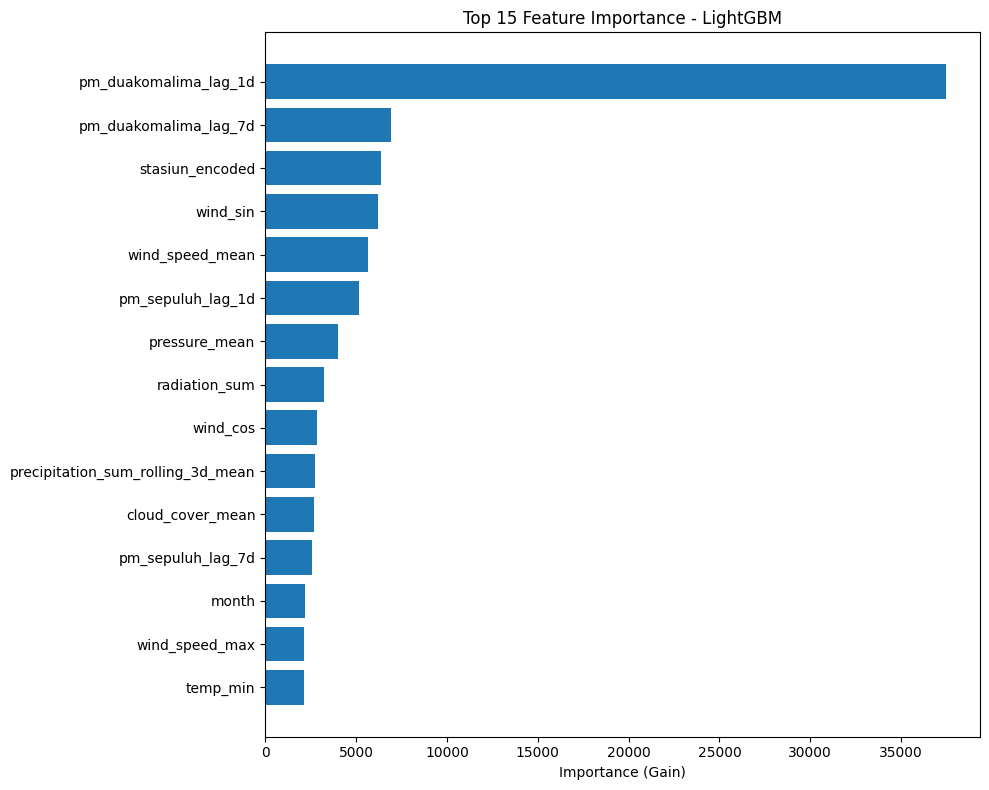


📊 Top 10 Features:
                          feature   importance
            pm_duakomalima_lag_1d 37470.120991
            pm_duakomalima_lag_7d  6943.817714
                  stasiun_encoded  6370.490903
                         wind_sin  6225.143441
                  wind_speed_mean  5668.431318
                pm_sepuluh_lag_1d  5164.273428
                    pressure_mean  4024.445193
                    radiation_sum  3254.148201
                         wind_cos  2872.767379
precipitation_sum_rolling_3d_mean  2753.611350


In [8]:
# =============================================================================
# CELL 7: Feature Importance
# =============================================================================
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': FEATURES,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance (Gain)')
plt.title('Top 15 Feature Importance - LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
print(feature_importance.head(10).to_string(index=False))

In [9]:
# =============================================================================
# CELL 8: Threshold Moving - Custom Threshold untuk Sensitivity
# =============================================================================
"""
THRESHOLD MOVING:
Alih-alih menggunakan argmax(probabilities), kita bisa menggunakan threshold
kustom untuk lebih sensitif terhadap kelas tertentu (BAIK & TIDAK SEHAT).
"""

# Get probabilities
y_proba = model.predict(X_test)

# Default prediction (argmax)
y_pred_default = np.argmax(y_proba, axis=1)

# Custom threshold: Lebih sensitif ke BAIK (0) dan TIDAK SEHAT (2)
THRESHOLDS = {
    0: 0.25,  # BAIK - turunkan threshold (lebih sensitif)
    1: 0.50,  # SEDANG - default
    2: 0.20,  # TIDAK SEHAT - turunkan threshold (lebih sensitif)
}

def apply_custom_threshold(proba, thresholds):
    """Apply custom thresholds per class."""
    predictions = []
    for p in proba:
        above_threshold = []
        for cls, thresh in thresholds.items():
            if p[cls] >= thresh:
                above_threshold.append((cls, p[cls]))
        
        if above_threshold:
            pred = max(above_threshold, key=lambda x: x[1])[0]
        else:
            pred = np.argmax(p)
        predictions.append(pred)
    return np.array(predictions)

y_pred_custom = apply_custom_threshold(y_proba, THRESHOLDS)

print("📊 Comparison: Default vs Custom Threshold")
print("=" * 60)
print("\n--- Default (argmax) ---")
print(classification_report(y_test, y_pred_default, target_names=list(CATEGORY_MAP.keys())))
print("\n--- Custom Threshold (more sensitive to BAIK & TIDAK SEHAT) ---")
print(classification_report(y_test, y_pred_custom, target_names=list(CATEGORY_MAP.keys())))

📊 Comparison: Default vs Custom Threshold

--- Default (argmax) ---
              precision    recall  f1-score   support

        BAIK       0.59      0.48      0.53       213
      SEDANG       0.80      0.78      0.79       849
 TIDAK SEHAT       0.41      0.56      0.47       141

    accuracy                           0.70      1203
   macro avg       0.60      0.61      0.60      1203
weighted avg       0.71      0.70      0.71      1203


--- Custom Threshold (more sensitive to BAIK & TIDAK SEHAT) ---
              precision    recall  f1-score   support

        BAIK       0.59      0.50      0.54       213
      SEDANG       0.80      0.78      0.79       849
 TIDAK SEHAT       0.41      0.57      0.48       141

    accuracy                           0.71      1203
   macro avg       0.60      0.62      0.60      1203
weighted avg       0.72      0.71      0.71      1203



In [10]:
# =============================================================================
# CELL 9: Prepare Submission Data & Historical Data for Recursive Forecasting
# =============================================================================
# Load sample submission
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
print(f"✓ Sample submission: {len(sample_sub)} rows")

# Parse id column -> tanggal dan stasiun
sample_sub['tanggal'] = pd.to_datetime(sample_sub['id'].str.split('_').str[0])
sample_sub['stasiun'] = sample_sub['id'].str.split('_').str[1]

# Get last known data untuk recursive forecasting
last_known_date = df['tanggal'].max()
print(f"\n✓ Last known date in training data: {last_known_date.date()}")
print(f"   Submission date range: {sample_sub['tanggal'].min().date()} to {sample_sub['tanggal'].max().date()}")

# Prepare historical PM values per station untuk recursive forecasting
# Ini akan di-update secara iteratif saat prediksi
pm_history = {}
for station in df['stasiun'].unique():
    station_data = df[df['stasiun'] == station].sort_values('tanggal')
    pm_history[station] = {
        'pm10': station_data[['tanggal', 'pm_sepuluh']].set_index('tanggal')['pm_sepuluh'].to_dict(),
        'pm25': station_data[['tanggal', 'pm_duakomalima']].set_index('tanggal')['pm_duakomalima'].to_dict()
    }
    
print(f"\n✓ Historical PM data prepared for {len(pm_history)} stations")
print(f"   Recursive lookback: {LOOKBACK_DAYS} day(s)")

✓ Sample submission: 455 rows

✓ Last known date in training data: 2025-08-31
   Submission date range: 2025-09-01 to 2025-11-30

✓ Historical PM data prepared for 13 stations
   Recursive lookback: 1 day(s)


In [11]:
# =============================================================================
# CELL 10: Recursive Forecasting (Compact)
# =============================================================================
CAT_PM = {0: (30, 41), 1: (54, 75), 2: (72, 110)}
numeric_feats = [f for f in FEATURES if f != 'stasiun_encoded']

# Precompute station-month medians
df_stats = df[['stasiun', 'tanggal'] + numeric_feats].copy()
df_stats['month'] = df_stats['tanggal'].dt.month
for c in numeric_feats: df_stats[c] = pd.to_numeric(df_stats[c], errors='coerce')
stats = df_stats.groupby(['stasiun', 'month'])[numeric_feats].median()
global_med = df_stats[numeric_feats].median()

sample_sub_sorted = sample_sub.sort_values(['tanggal', 'stasiun']).reset_index(drop=True)
pred_cats, preds = {}, []

print(f"🔄 Recursive Forecasting ({len(sample_sub_sorted)} predictions)")

for idx, row in sample_sub_sorted.iterrows():
    np.random.seed(RANDOM_STATE + idx * 3)
    st, dt = row['stasiun'], row['tanggal']
    m, wknd = dt.month, int(dt.dayofweek >= 5)
    
    feat = stats.loc[(st, m)].to_dict() if (st, m) in stats.index else global_med.to_dict()
    
    # Recursive lags
    for d, sfx in [(1, '_lag_1d'), (7, '_lag_7d')]:
        prev = dt - pd.Timedelta(days=d)
        if (st, prev) in pred_cats:
            pm10, pm25 = CAT_PM[pred_cats[(st, prev)]]
            feat[f'pm_sepuluh{sfx}'] = pm10 * np.random.uniform(0.7, 1.3)
            feat[f'pm_duakomalima{sfx}'] = pm25 * np.random.uniform(0.7, 1.3)
        else:
            feat[f'pm_sepuluh{sfx}'] = np.random.uniform(25, 80)
            feat[f'pm_duakomalima{sfx}'] = np.random.uniform(35, 120)
    
    if wknd: feat['pm_sepuluh_lag_1d'] *= 0.85; feat['pm_duakomalima_lag_1d'] *= 0.85
    
    feat.update({'year': dt.year, 'month': m, 'is_weekend': wknd, 'is_holiday_nasional': 0,
                 'stasiun_encoded': le_stasiun.transform([st])[0] if st in le_stasiun.classes_ else 0})
    
    proba = model.predict(pd.DataFrame([feat])[FEATURES].fillna(0))[0]
    adj = [proba[0] * 1.8, proba[1] * 0.6, proba[2] * 1.5]  # Boost minority
    pred = np.argmax(adj)
    pred_cats[(st, dt)] = pred
    preds.append(pred)

sample_sub_sorted['category'] = [REVERSE_MAP[p] for p in preds]
sample_sub = sample_sub_sorted.sort_index()

print(f"📊 {sample_sub['category'].value_counts().to_dict()}")
print(sample_sub[['id','category']].head(10).to_string(index=False))

🔄 Recursive Forecasting (455 predictions)
📊 {'SEDANG': 341, 'BAIK': 60, 'TIDAK SEHAT': 54}
             id    category
2025-09-01_DKI1 TIDAK SEHAT
2025-09-01_DKI2      SEDANG
2025-09-01_DKI3 TIDAK SEHAT
2025-09-01_DKI4      SEDANG
2025-09-01_DKI5      SEDANG
2025-09-02_DKI1 TIDAK SEHAT
2025-09-02_DKI2      SEDANG
2025-09-02_DKI3      SEDANG
2025-09-02_DKI4      SEDANG
2025-09-02_DKI5      SEDANG


In [12]:
# =============================================================================
# CELL 11: Save Submission
# =============================================================================
submission = sample_sub[['id', 'category']]
submission.to_csv("../processed_data/submission_lightgbmUpgrade.csv", index=False)

print(f"✓ Saved: submission_lightgbmUpgrade.csv ({len(submission)} rows)")
print(submission.head(10))

✓ Saved: submission_lightgbmUpgrade.csv (455 rows)
                id     category
0  2025-09-01_DKI1  TIDAK SEHAT
1  2025-09-01_DKI2       SEDANG
2  2025-09-01_DKI3  TIDAK SEHAT
3  2025-09-01_DKI4       SEDANG
4  2025-09-01_DKI5       SEDANG
5  2025-09-02_DKI1  TIDAK SEHAT
6  2025-09-02_DKI2       SEDANG
7  2025-09-02_DKI3       SEDANG
8  2025-09-02_DKI4       SEDANG
9  2025-09-02_DKI5       SEDANG
